In [1]:
# import needed libs

%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

# usual imports for visualization, etc.
import numpy as np
import matplotlib.pyplot as plt

import datetime

# make it reproducible
np.random.seed(0)

env_name = 'smart-vac'
# just_plot = False
just_plot = True

# show plots inline
%matplotlib inline

In [2]:
# Some initializations

from envs import SmartVac
from agents import ReinforceAgent, ReinforceWithBaselineAgent, ActorCriticAgent

max_episode_steps = 100
results_folder = 'res/'
figs_folder = 'figs/'
output_folder = 'output/'

!mkdir output

A subdirectory or file output already exists.


In [3]:
best_performance = 0.63
env = SmartVac()

In [4]:
from cycler import cycler
def set_plt_rc():
    font = {'family': 'serif','size': 12}
    plt.rc('text', usetex=True)

    
#     SMALL_SIZE = 8
#     MEDIUM_SIZE = 10
#     BIGGER_SIZE = 12

#     plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#     plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#     plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#     plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#     plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#     plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#     plt.rc('font', family='serif')
    plt.rc('font', family=font['family'], size=font['size'])
    
    
#     plt.rc('xtick', labelsize='x-small')
#     plt.rc('ytick', labelsize='x-small')
    
    plt.rc('xtick', labelsize='medium')
    plt.rc('ytick', labelsize='medium')
    
    plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    
set_plt_rc()



#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    t = ax.text(x,y,label,rotation=trans_angle,**kwargs)
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

def labelLines(lines,align=True,xvals=None,labels=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    
    label_available = True
    if labels is None:
        label_available = False
        labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)
        else:
            labLines.append(line)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]
        
    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

# REINFORCE Agent

In [17]:
AgentClass = ReinforceAgent
agent_name = AgentClass.__name__

alpha_base = 2
alpha_pows = np.linspace(-8, -1, 8)
alphas = np.power(alpha_base, alpha_pows)

num_of_tests = 10
episode_count = 10000
plot_count = int(episode_count / 100)

In [18]:
if not just_plot:
    all_avg_plots = []
    all_avgs = []
    all_bests = []
    all_lasts = []
    all_stds = []
    for alpha_pow in alpha_pows:
        alpha = np.power(alpha_base, alpha_pow)
        params_str = f'alpha={alpha_base}^{alpha_pow:.2f}_episodes_{episode_count}'    
        mult_avgs = []
        mult_probs1 = []
        mult_probs2 = []
        for i_test in range(num_of_tests):
            print()
            print(i_test + 1, end=' ')

            # Initialize the agent
            agent = AgentClass(alpha=alpha)

            avgs = []
            probs1 = []
            probs2 = []

            episode_rewards = np.zeros(episode_count)
            for i_episode in range(episode_count):
                done = False
                totalReward = 0

                if i_episode >= plot_count and (i_episode % plot_count == 0):
                    avg = np.average(episode_rewards[i_episode - plot_count:i_episode])
                    avgs.append(avg)

                    # deterministic position
                    env.x = 0
                    env.y = 1
                    obs = env.get_obs()
                    prob = agent.get_action_vals_for_obs(obs)
                    probs1.append(prob)

                    # stochastic position
                    env.x = 1
                    env.y = 1
                    obs = env.get_obs()
                    prob = agent.get_action_vals_for_obs(obs)
                    probs2.append(prob)

                    print('#', end='', flush=True)
                    if len(avgs) % 100 == 0:
                        print(i_episode)

                obs = env.reset()
                action = agent.start(obs)

                step = 0
                while not done:
                    obs, reward, done = env.step(action)
                    action = agent.step(obs, reward, done)
                    totalReward += reward

                    step += 1
                    if step > max_episode_steps:
                        done = True

                episode_rewards[i_episode] = totalReward
                agent.update_for_episode()

            mult_avgs.append(avgs)
            mult_probs1.append(probs1)
            mult_probs2.append(probs2)

        avgs = np.mean(np.array(mult_avgs), axis=0)
        std_avg = np.std(np.mean(np.array(mult_avgs), axis=1), axis=0)
        probs1 = np.mean(np.array(mult_probs1), axis=0)
        probs2 = np.mean(np.array(mult_probs2), axis=0)

        all_avgs.append(np.mean(avgs))
        all_bests.append(np.max(avgs))
        all_lasts.append(avgs[-1])
        all_avg_plots.append(avgs)
        all_stds.append(std_avg)

        results = f'\n\nAgent: {agent_name} \tAlpha: {alpha}'
        results += f'\nAverage: \t\t{np.mean(avgs):5.3f}'
        results += f'\nBest {plot_count} Average: \t{np.max(avgs):5.3f}'
        results += f'\nLast {plot_count} Average: \t{avgs[-1]:5.3f}'
        print(results)

In [19]:
# Save Results
import pickle

pkl_file_name = f'{output_folder}{env_name}-{agent_name}.pkl'
print(pkl_file_name)

if not just_plot:
    res_vars = {
        'all_avg_plots': all_avg_plots,
        'alpha_base': alpha_base,
        'alpha_pows': alpha_pows,
        'alphas': alphas,
        'all_avgs': all_avgs,
        'num_of_tests': num_of_tests,
        'all_stds': all_stds,
        'agent_name': agent_name,
    }

    with open(pkl_file_name, "wb") as f:
        pickle.dump(res_vars, f)

output/smart-vac-ReinforceAgent.pkl


In [20]:
# Load Results
import pickle

if just_plot:
    res_vars = {}
    with open(pkl_file_name, "rb") as f:
        res_vars = pickle.load(f)

    for var in res_vars:
        vars()[var] = res_vars[var]

In [21]:
all_avgs = np.array(all_avgs)
idx = np.argmax(all_avgs)
results = f'Best Average: {all_avgs[idx]}'
results += f'\nConfig: Alpha={alphas[idx]}'

print('')
print(results)


Best Average: 0.592690909090909
Config: Alpha=0.125


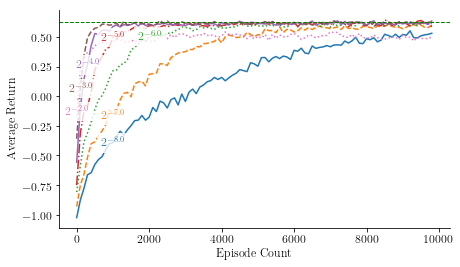

In [28]:
# Testing with labeling
# Plot over time
plt.figure(1, figsize=(7,4))
plt.plot(np.array(list(range(len(all_avg_plots[0]))))*plot_count, np.array(all_avg_plots[:-1]).T)
# plt.title(f'Average Return in {episode_count} episodes')
plt.xlabel(f'Episode Count')
# plt.ylabel(f'Average Return in {plot_count} episodes')
plt.ylabel(f'Average Return')
# plt.ylabel(f'Total reward on episode averaged over {plot_count} episodes and {num_of_tests} runs')
# plt.ylabel(f'Total Reward on Episode')
# plt.legend([f'alpha={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows[:-1]])
plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')

lines = plt.gca().get_lines()
l1=lines[-1]
# labelLine(l1,0.6,label=r'$Re=${}'.format(l1.get_label()),ha='left',va='bottom',align = False)

ax = lines[0].axes
xmin,xmax = ax.get_xlim()
labLines = [f'${alpha_base}^{{ {alpha_pow:.1f} }}$' for alpha_pow in alpha_pows[:-1]]
xvals = np.linspace(xmax,xmin,len(labLines)+2)[1:-1]
xvals[0] = 1000
xvals[1] = 1000
xvals[2] = 2000
xvals[3] = 1000
xvals[4] = 300
xvals[5] = 100
xvals[6] = 10
labelLines(lines,align=False,labels=labLines,
          xvals = xvals)
plt.savefig(f'{figs_folder}smart_vac_{agent_name}_episodes_{episode_count}_leg.pdf')
plt.show()

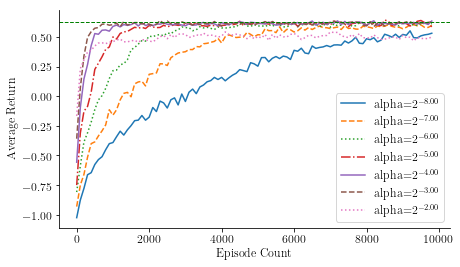

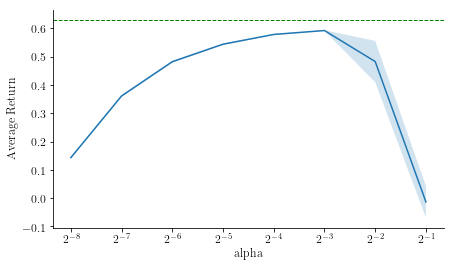

In [11]:
# Plot over time
plt.figure(1, figsize=(7,4))
plt.plot(np.array(list(range(len(all_avg_plots[0]))))*plot_count, np.array(all_avg_plots[:-1]).T)
# plt.title(f'Average Return in {episode_count} episodes')
plt.xlabel(f'Episode Count')
# plt.ylabel(f'Average Return in {plot_count} episodes')
plt.ylabel(f'Average Return')
# plt.ylabel(f'Total reward on episode averaged over {plot_count} episodes and {num_of_tests} runs')
# plt.ylabel(f'Total Reward on Episode')
plt.legend([f'alpha=${alpha_base}^{{ {alpha_pow:.2f} }}$' for alpha_pow in alpha_pows[:-1]])
plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
# plt.ylim(best_performance-2.13,best_performance+.07)
plt.savefig(f'{figs_folder}smart_vac_{agent_name}_episodes_{episode_count}.pdf')


# Plot Average Performance
plt.figure(2, figsize=(7,4))
plt.semilogx(alphas, all_avgs, basex=alpha_base)
se = np.array(all_stds) / np.sqrt(num_of_tests)
plt.fill_between(alphas, all_avgs - se, all_avgs + se, alpha=0.2)
# plt.title(f'Average Return in {episode_count} episodes')
plt.xlabel('alpha')
plt.ylabel('Average Return')
# plt.ylabel(f'Total reward on episodes averaged over {num_of_tests} runs')
# plt.ylabel(f'Average Total Reward on Episode')
plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
# plt.ylim(best_performance-2.13,best_performance+.07)
plt.savefig(f'{figs_folder}smart_vac_{agent_name}_episodes_{episode_count}_all.pdf')

# REINFORCE with Baseline Agent

In [12]:
AgentClass = ReinforceWithBaselineAgent

alpha_base = 2
alpha_pows_w = np.linspace(-5, 0, 6)
alpha_pows_theta = np.linspace(-7, 0, 8)
alphas_w = np.power(alpha_base, alpha_pows_w)
alphas_theta = np.power(alpha_base, alpha_pows_theta)
print(alphas_w)
print(alphas_theta)

num_of_tests = 10
episode_count = 10000
plot_count = int(episode_count / 100)

agent_name = AgentClass.__name__

if not just_plot:
    results = ""
    all_best_avgs = []
    all_best_alpha_thetas = []
    all_total_avgs = []
    all_total_bests = []
    all_total_lasts = []
    all_total_stds = []
    for alpha_pow_w in alpha_pows_w:
        all_avgs = []
        all_bests = []
        all_lasts = []
        all_stds = []
        alpha_w = np.power(alpha_base, alpha_pow_w)
        for alpha_pow_theta in alpha_pows_theta:
            alpha_theta = np.power(alpha_base, alpha_pow_theta)
            params_str = f'alpha_w_{alpha_w}_alpha_theta_{alpha_theta}_episodes_{episode_count}'
            mult_avgs = []
            for i_test in range(num_of_tests):
                print()
                print(i_test + 1, end=' ')

                # Initialize the agent
                agent = AgentClass(alpha_theta=alpha_theta, alpha_w=alpha_w)

                avgs = []
                probs1 = []
                probs2 = []

                episode_rewards = np.zeros(episode_count)
                for i_episode in range(episode_count):
                    done = False
                    totalReward = 0

                    if i_episode >= plot_count and (i_episode % plot_count == 0):
                        avg = np.average(episode_rewards[i_episode - plot_count:i_episode])
                        avgs.append(avg)

                        # deterministic position
                        env.x = 0
                        env.y = 1
                        obs = env.get_obs()
                        prob = agent.get_action_vals_for_obs(obs)
                        probs1.append(prob)

                        # stochastic position
                        env.x = 1
                        env.y = 1
                        obs = env.get_obs()
                        prob = agent.get_action_vals_for_obs(obs)
                        probs2.append(prob)

                        print('#', end='', flush=True)
                        if len(avgs) % 100 == 0:
                            print(i_episode)

                    obs = env.reset()
                    action = agent.start(obs)

                    step = 0
                    while not done:
                        obs, reward, done = env.step(action)
                        action = agent.step(obs, reward, done)
                        totalReward += reward

                        step += 1
                        if step > max_episode_steps:
                            done = True

                    episode_rewards[i_episode] = totalReward
                    agent.update_for_episode()

                mult_avgs.append(avgs)

            avgs = np.mean(np.array(mult_avgs), axis=0)
            std_avg = np.std(np.mean(np.array(mult_avgs), axis=1), axis=0)

            all_avgs.append(np.mean(avgs))
            all_bests.append(np.max(avgs))
            all_lasts.append(avgs[-1])
            all_stds.append(std_avg)

            results_tmp = f'\n\nAgent: {agent_name} \tAlpha_w: {alpha_w}\tAlpha_theta: {alpha_theta}'
            results_tmp += f'\nAverage: \t\t{np.mean(avgs):5.3f}'
            results_tmp += f'\nBest {plot_count} Average: \t{np.max(avgs):5.3f}'
            results_tmp += f'\nLast {plot_count} Average: \t{avgs[-1]:5.3f}'
            print(results_tmp)

            results += results_tmp

        # print best results
        all_avgs = np.array(all_avgs)
        idx = np.argmax(all_avgs)
        all_best_avgs.append(all_avgs[idx])
        all_best_alpha_thetas.append(alphas_theta[idx])

        # Save for plotting
        all_total_avgs.append(all_avgs)
        all_total_bests.append(all_bests)
        all_total_lasts.append(all_lasts)
        all_total_stds.append(all_stds)

[0.03125 0.0625  0.125   0.25    0.5     1.     ]
[0.0078125 0.015625  0.03125   0.0625    0.125     0.25      0.5
 1.       ]


In [13]:
# Save Results
import pickle

pkl_file_name = f'{output_folder}{env_name}-{agent_name}.pkl'
print(pkl_file_name)

if not just_plot:
    res_vars = {
        'agent_name': agent_name,
        'all_best_avgs': all_best_avgs,
        'alphas_w': alphas_w,
        'all_best_alpha_thetas': all_best_alpha_thetas,
        'alpha_base': alpha_base,
        'all_total_avgs': all_total_avgs,
        'all_total_bests': all_total_bests,
        'all_total_lasts': all_total_lasts,
        'all_total_stds': all_total_stds,
        'alphas_theta': alphas_theta,
        'alpha_pows_w': alpha_pows_w,
        'alpha_pows_theta': alpha_pows_theta,
    }

    with open(pkl_file_name, "wb") as f:
        pickle.dump(res_vars, f)

output/smart-vac-ReinforceWithBaselineAgent.pkl


In [14]:
# Load Results
import pickle

if just_plot:
    res_vars = {}
    with open(pkl_file_name, "rb") as f:
        res_vars = pickle.load(f)

    for var in res_vars:
        vars()[var] = res_vars[var]

In [15]:
# Print best results
all_best_avgs = np.array(all_best_avgs)
idx = np.argmax(all_best_avgs)
results_tmp = f'Best Average: {all_best_avgs[idx]}'
results_tmp += f'\nConfig: Alpha_w={alphas_w[idx]}, Alpha_theta={all_best_alpha_thetas[idx]}'

print('')
print(results_tmp)


Best Average: 0.5881131313131313
Config: Alpha_w=0.5, Alpha_theta=0.25


In [16]:
all_total_avgs = np.array(all_total_avgs)
all_total_stds = np.array(all_total_stds)
plt.figure(1, figsize=(7, 4))

for i in range(all_total_avgs.shape[0]):
    all_avgs = all_total_avgs[i, :]
    plt.semilogx(alphas_theta, all_avgs, basex=alpha_base)
    se = np.array(all_total_stds[i, :]) / np.sqrt(num_of_tests)
    plt.fill_between(alphas_theta, all_avgs - se, all_avgs + se, alpha=0.2)
# plt.title(f'Average Return in {episode_count} Episodes')
plt.xlabel('alpha_theta')
plt.ylabel('Average Return')
# plt.ylabel('Average Total Reward on Episode')
plt.legend(
    [f'alpha_w={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows_w])
plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
# plt.ylim(best_performance-2.13, best_performance+.07)
plt.savefig(f'{figs_folder}smart_vac_{agent_name}_episodes_{episode_count}_all.pdf')

RuntimeError: LaTeX was not able to process the following string:
b'alpha_theta'

Here is the full report generated by LaTeX:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (MiKTeX 2.9.6880 64-bit)
entering extended mode
(bddd91aba9c84b18555cb68520cb0117.tex
LaTeX2e <2018-04-01> patch level 5
("D:\Program Files\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("D:\Program Files\MiKTeX 2.9\tex\latex\base\size10.clo"))
("D:\Program Files\MiKTeX 2.9\tex\latex\type1cm\type1cm.sty")
("D:\Program Files\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("D:\Program Files\MiKTeX 2.9\tex\latex\base\ts1enc.def"
("D:\Program Files\MiKTeX 2.9\tex\latex\base\ts1enc.dfu")))
("D:\Program Files\MiKTeX 2.9\tex\latex\geometry\geometry.sty"
("D:\Program Files\MiKTeX 2.9\tex\latex\graphics\keyval.sty")
("D:\Program Files\MiKTeX 2.9\tex\generic\oberdiek\ifpdf.sty")
("D:\Program Files\MiKTeX 2.9\tex\generic\oberdiek\ifvtex.sty")
("D:\Program Files\MiKTeX 2.9\tex\generic\ifxetex\ifxetex.sty")
("D:\Program Files\MiKTeX 2.9\tex\latex\geometry\geometry.cfg")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file bddd91aba9c84b18555cb68520cb0117.aux.
("D:\Program Files\MiKTeX 2.9\tex\latex\base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ...ize{12.000000}{15.000000}{\rmfamily alpha_
                                                  theta}
! Extra }, or forgotten $.
l.12 ....000000}{15.000000}{\rmfamily alpha_theta}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (bddd91aba9c84b18555cb68520cb0117.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on bddd91aba9c84b18555cb68520cb0117.dvi (1 page, 348 bytes).
Transcript written on bddd91aba9c84b18555cb68520cb0117.log.
 



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000012FC17C7D08> (for post_execute):


RuntimeError: LaTeX was not able to process the following string:
b'alpha_w=2^-5.00'

Here is the full report generated by LaTeX:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (MiKTeX 2.9.6880 64-bit)
entering extended mode
(5400839e5928b70e7f8a7003e7733315.tex
LaTeX2e <2018-04-01> patch level 5
("D:\Program Files\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("D:\Program Files\MiKTeX 2.9\tex\latex\base\size10.clo"))
("D:\Program Files\MiKTeX 2.9\tex\latex\type1cm\type1cm.sty")
("D:\Program Files\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("D:\Program Files\MiKTeX 2.9\tex\latex\base\ts1enc.def"
("D:\Program Files\MiKTeX 2.9\tex\latex\base\ts1enc.dfu")))
("D:\Program Files\MiKTeX 2.9\tex\latex\geometry\geometry.sty"
("D:\Program Files\MiKTeX 2.9\tex\latex\graphics\keyval.sty")
("D:\Program Files\MiKTeX 2.9\tex\generic\oberdiek\ifpdf.sty")
("D:\Program Files\MiKTeX 2.9\tex\generic\oberdiek\ifvtex.sty")
("D:\Program Files\MiKTeX 2.9\tex\generic\ifxetex\ifxetex.sty")
("D:\Program Files\MiKTeX 2.9\tex\latex\geometry\geometry.cfg")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 5400839e5928b70e7f8a7003e7733315.aux.
("D:\Program Files\MiKTeX 2.9\tex\latex\base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ...ize{12.000000}{15.000000}{\rmfamily alpha_
                                                  w=2^-5.00}
! Extra }, or forgotten $.
l.12 ...000}{15.000000}{\rmfamily alpha_w=2^-5.00}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (5400839e5928b70e7f8a7003e7733315.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 5400839e5928b70e7f8a7003e7733315.dvi (1 page, 408 bytes).
Transcript written on 5400839e5928b70e7f8a7003e7733315.log.
 



RuntimeError: LaTeX was not able to process the following string:
b'alpha_w=2^-4.00'

Here is the full report generated by LaTeX:
This is pdfTeX, Version 3.14159265-2.6-1.40.19 (MiKTeX 2.9.6880 64-bit)
entering extended mode
(3779d3cc55802d5bdf2a980ef9795596.tex
LaTeX2e <2018-04-01> patch level 5
("D:\Program Files\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("D:\Program Files\MiKTeX 2.9\tex\latex\base\size10.clo"))
("D:\Program Files\MiKTeX 2.9\tex\latex\type1cm\type1cm.sty")
("D:\Program Files\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("D:\Program Files\MiKTeX 2.9\tex\latex\base\ts1enc.def"
("D:\Program Files\MiKTeX 2.9\tex\latex\base\ts1enc.dfu")))
("D:\Program Files\MiKTeX 2.9\tex\latex\geometry\geometry.sty"
("D:\Program Files\MiKTeX 2.9\tex\latex\graphics\keyval.sty")
("D:\Program Files\MiKTeX 2.9\tex\generic\oberdiek\ifpdf.sty")
("D:\Program Files\MiKTeX 2.9\tex\generic\oberdiek\ifvtex.sty")
("D:\Program Files\MiKTeX 2.9\tex\generic\ifxetex\ifxetex.sty")
("D:\Program Files\MiKTeX 2.9\tex\latex\geometry\geometry.cfg")

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 3779d3cc55802d5bdf2a980ef9795596.aux.
("D:\Program Files\MiKTeX 2.9\tex\latex\base\ts1cmr.fd")
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ...ize{12.000000}{15.000000}{\rmfamily alpha_
                                                  w=2^-4.00}
! Extra }, or forgotten $.
l.12 ...000}{15.000000}{\rmfamily alpha_w=2^-4.00}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (3779d3cc55802d5bdf2a980ef9795596.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 3779d3cc55802d5bdf2a980ef9795596.dvi (1 page, 408 bytes).
Transcript written on 3779d3cc55802d5bdf2a980ef9795596.log.
 



In [ ]:
all_total_avgs = np.array(all_total_avgs)
all_total_stds = np.array(all_total_stds)
plt.figure(1, figsize=(7, 4))

for i in range(all_total_avgs.shape[0]):
    all_avgs = all_total_avgs[i, :]
    plt.semilogx(alphas_theta, all_avgs, basex=alpha_base)
    se = np.array(all_total_stds[i, :]) / np.sqrt(num_of_tests)
    plt.fill_between(alphas_theta, all_avgs - se, all_avgs + se, alpha=0.2)
# plt.title(f'Average Return in {episode_count} Episodes')
plt.xlabel('alpha_theta')
plt.ylabel('Average Return')
# plt.ylabel('Average Total Reward on Episode')
plt.legend(
    [f'alpha_w={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows_w])
plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
# plt.ylim(best_performance-2.13, best_performance+.07)
plt.savefig(f'{figs_folder}smart_vac_{agent_name}_episodes_{episode_count}_all.pdf')

lines = plt.gca().get_lines()
l1=lines[-1]
# labelLine(l1,0.6,label=r'$Re=${}'.format(l1.get_label()),ha='left',va='bottom',align = False)

# ax = lines[0].axes
# xmin,xmax = ax.get_xlim()
# # xmax = 4000
# labLines = [f'alpha_w={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows_w]
# xvals = np.logspace(np.log2(xmin),np.log2(xmax),len(labLines)+2,base=2)[1:-1]
# labelLines(lines,align=False,labels=labLines,
#           xvals = xvals)

# Actor-Critic Agent

In [ ]:
AgentClass = ActorCriticAgent

alpha_base = 2
alpha_pows_w = np.linspace(-5, -1, 3)
alpha_pows_theta = np.linspace(-5, 2, 8)
alphas_w = np.power(alpha_base, alpha_pows_w)
alphas_theta = np.power(alpha_base, alpha_pows_theta)
print(alphas_w)
print(alphas_theta)

num_of_tests = 10
episode_count = 10000
plot_count = int(episode_count / 100)

agent_name = AgentClass.__name__

if not just_plot:
    results = ""
    all_best_avgs = []
    all_best_alpha_thetas = []
    all_total_avgs = []
    all_total_bests = []
    all_total_lasts = []
    all_total_stds = []
    for alpha_pow_w in alpha_pows_w:
        all_avgs = []
        all_bests = []
        all_lasts = []
        all_stds = []
        alpha_w = np.power(alpha_base, alpha_pow_w)
        for alpha_pow_theta in alpha_pows_theta:
            alpha_theta = np.power(alpha_base, alpha_pow_theta)
            params_str = f'alpha_w_{alpha_w}_alpha_theta_{alpha_theta}_episodes_{episode_count}'
            mult_avgs = []
            for i_test in range(num_of_tests):
                print()
                print(i_test + 1, end=' ')

                # Initialize the agent
                agent = AgentClass(alpha_theta=alpha_theta, alpha_w=alpha_w)

                avgs = []
                probs1 = []
                probs2 = []

                episode_rewards = np.zeros(episode_count)
                for i_episode in range(episode_count):
                    done = False
                    totalReward = 0

                    if i_episode >= plot_count and (i_episode % plot_count == 0):
                        avg = np.average(episode_rewards[i_episode - plot_count:i_episode])
                        avgs.append(avg)

                        # deterministic position
                        env.x = 0
                        env.y = 1
                        obs = env.get_obs()
                        prob = agent.get_action_vals_for_obs(obs)
                        probs1.append(prob)

                        # stochastic position
                        env.x = 1
                        env.y = 1
                        obs = env.get_obs()
                        prob = agent.get_action_vals_for_obs(obs)
                        probs2.append(prob)

                        print('#', end='', flush=True)
                        if len(avgs) % 100 == 0:
                            print(i_episode)

                    obs = env.reset()
                    action = agent.start(obs)

                    step = 0
                    while not done:
                        obs, reward, done = env.step(action)
                        action = agent.step(obs, reward, done)
                        totalReward += reward

                        step += 1
                        if step > max_episode_steps:
                            done = True

                    episode_rewards[i_episode] = totalReward
                    agent.update_for_episode()

                mult_avgs.append(avgs)

            avgs = np.mean(np.array(mult_avgs), axis=0)
            std_avg = np.std(np.mean(np.array(mult_avgs), axis=1), axis=0)

            all_avgs.append(np.mean(avgs))
            all_bests.append(np.max(avgs))
            all_lasts.append(avgs[-1])
            all_stds.append(std_avg)

            results_tmp = f'\n\nAgent: {agent_name} \tAlpha_w: {alpha_w}\tAlpha_theta: {alpha_theta}'
            results_tmp += f'\nAverage: \t\t{np.mean(avgs):5.3f}'
            results_tmp += f'\nBest {plot_count} Average: \t{np.max(avgs):5.3f}'
            results_tmp += f'\nLast {plot_count} Average: \t{avgs[-1]:5.3f}'
            print(results_tmp)

            results += results_tmp

        # print best results
        all_avgs = np.array(all_avgs)
        idx = np.argmax(all_avgs)
        all_best_avgs.append(all_avgs[idx])
        all_best_alpha_thetas.append(alphas_theta[idx])

        # Save for plotting
        all_total_avgs.append(all_avgs)
        all_total_bests.append(all_bests)
        all_total_lasts.append(all_lasts)
        all_total_stds.append(all_stds)

In [ ]:
# Save Results
import pickle

pkl_file_name = f'{output_folder}{env_name}-{agent_name}.pkl'
print(pkl_file_name)

if not just_plot:
    res_vars = {
        'agent_name': agent_name,
        'all_best_avgs': all_best_avgs,
        'alphas_w': alphas_w,
        'all_best_alpha_thetas': all_best_alpha_thetas,
        'alpha_base': alpha_base,
        'all_total_avgs': all_total_avgs,
        'all_total_bests': all_total_bests,
        'all_total_lasts': all_total_lasts,
        'all_total_stds': all_total_stds,
        'alphas_theta': alphas_theta,
        'alpha_pows_w': alpha_pows_w,
        'alpha_pows_theta': alpha_pows_theta,
    }

    with open(pkl_file_name, "wb") as f:
        pickle.dump(res_vars, f)

In [ ]:
# Load Results
import pickle

if just_plot:
    res_vars = {}
    with open(pkl_file_name, "rb") as f:
        res_vars = pickle.load(f)

    for var in res_vars:
        vars()[var] = res_vars[var]

In [ ]:
# Print best results
all_best_avgs = np.array(all_best_avgs)
idx = np.argmax(all_best_avgs)
results_tmp = f'Best Average: {all_best_avgs[idx]}'
results_tmp += f'\nConfig: Alpha_w={alphas_w[idx]}, Alpha_theta={all_best_alpha_thetas[idx]}'

print('')
print(results_tmp)

In [ ]:
all_total_avgs = np.array(all_total_avgs)
all_total_stds = np.array(all_total_stds)
plt.figure(1, figsize=(7, 4))

for i in range(all_total_avgs.shape[0]):
    all_avgs = all_total_avgs[i, :]
    plt.semilogx(alphas_theta, all_avgs, basex=alpha_base)
    se = np.array(all_total_stds[i, :]) / np.sqrt(num_of_tests)
    plt.fill_between(alphas_theta, all_avgs - se, all_avgs + se, alpha=0.2)
# plt.title(f'Average Return in {episode_count} Episodes')
plt.xlabel('alpha_theta')
plt.ylabel('Average Return')
# plt.ylabel('Average Total Reward on Episode')
plt.legend(
    [f'alpha_w={alpha_base}^{alpha_pow:.2f}' for alpha_pow in alpha_pows_w])
plt.axhline(y=best_performance, linewidth=1, color="g", linestyle='--')
# plt.ylim(best_performance-2.13, best_performance+.07)
plt.savefig(f'{figs_folder}smart_vac_{agent_name}_episodes_{episode_count}_all.pdf')